In [1]:
from pytorch_modules.model import DistilBERTClass
from pytorch_modules.dataset import MultiLabelDataset
import torch
from pytorch_modules import config
import pandas as pd
from transformers import DistilBertTokenizer
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from pytorch_modules.utils import train, save_model

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
df = pd.read_csv(config.DATA_DIR)
tokenizer = DistilBertTokenizer.from_pretrained(
    "distilbert-base-uncased", truncation=True, do_lower_case=True
)
dataset = MultiLabelDataset(
    dataframe=df, tokenizer=tokenizer, max_len=config.MAX_LEN
)
train_set, val_set = random_split(
    dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(42)
)


In [3]:
train_set

In [4]:
trial_pass = train_set[0]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/stanley/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [5]:
ids = trial_pass['ids'].to(device, dtype = torch.long)
mask = trial_pass['mask'].to(device, dtype = torch.long)
token_type_ids = trial_pass['token_type_ids'].to(device, dtype = torch.long)
targets = trial_pass['targets'].to(device, dtype = torch.float)

In [15]:
model_trial = DistilBERTClass().to(device)
outputs = model_trial(ids, mask, token_type_ids).squeeze(dim=0)

In [16]:
print(outputs.squeeze(dim=0).shape, targets.shape)
print(outputs, targets)

torch.Size([6]) torch.Size([6])
tensor([-0.1301, -0.0243, -0.1516,  0.2207, -0.2031,  0.0527], device='cuda:0',
       grad_fn=<SqueezeBackward1>) tensor([0., 0., 0., 0., 0., 0.], device='cuda:0')


In [22]:
sigmoids = (torch.sigmoid(outputs))
rounded = torch.round(sigmoids)
output = torch.eq(targets, rounded).sum().item()/len(rounded)
output, rounded, sigmoids


(0.6666666666666666,
 tensor([0., 0., 0., 1., 0., 1.], device='cuda:0', grad_fn=<RoundBackward0>),
 tensor([0.4675, 0.4939, 0.4622, 0.5549, 0.4494, 0.5132], device='cuda:0',
        grad_fn=<SigmoidBackward0>))

In [3]:
train_dataloader = DataLoader(
    dataset=train_set,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=config.NUM_WORKERS,
)

val_dataloader = DataLoader(
    dataset=val_set,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=config.NUM_WORKERS,
)

model = DistilBERTClass()
model.to(device)

loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=config.LEARNING_RATE)


In [4]:


results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=val_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=config.EPOCHS,
    device=device,
)

save_model(model=model, target_dir="models/", model_name="test_model.pt")

  0%|          | 0/1 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Training Epoch 0:   0%|          | 0/12766 [00:00<?, ?it/s]

/home/stanley/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/stanley/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None 

Testing Epoch 0:   0%|          | 0/3192 [00:00<?, ?it/s]

/home/stanley/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 1 | train_loss: 0.0467 | train_acc: 0.9828 | test_loss: 0.0366 | test_acc: 0.9853 | train_epoch_time: 8919.3361 | test_epoch_time: 871.2157
[INFO] Saving model to: models/test_model.pt


In [5]:
results

{'train_results': [{'train_acc': [0.4166666865348816,
    0.9634551560363896,
    0.9707986752126062,
    0.9738623814762764,
    0.975992234521464,
    0.9768487733654146,
    0.9774939906987662,
    0.9780898042544475,
    0.9786894407087642,
    0.9791497036246448,
    0.9792402593424542,
    0.9795163142359715,
    0.9798343113083801,
    0.9800435844918637,
    0.980266609182814,
    0.9803525202540763,
    0.9804346376447671,
    0.9806541261591647,
    0.9808152871559205,
    0.9809624103470197,
    0.981097601032559,
    0.98120933801404,
    0.9813563663333569,
    0.9814737056272822,
    0.9816715333167422,
    0.9817491063609503,
    0.9818997626777735,
    0.9819528516053182,
    0.9820696011410911,
    0.9821763844918059,
    0.9822353135544835,
    0.9823531583616418,
    0.9824289200442767,
    0.9824815739129436,
    0.9825294969736531,
    0.9826048376752972,
    0.9826158135756885,
    0.9826382071507341,
    0.982669655262049,
    0.9826909445226829,
    0.9827042254

In [15]:
plot = {
"train_loss": results['train_results'][0]['train_loss'],
"train_acc": results['train_results'][0]['train_acc'],
"test_loss": results['test_results'][0]['test_loss'],
"test_acc": results['test_results'][0]['test_acc'],
"training_time": results['train_epoch_time'],
"testing_time": results['test_epoch_time'],
}

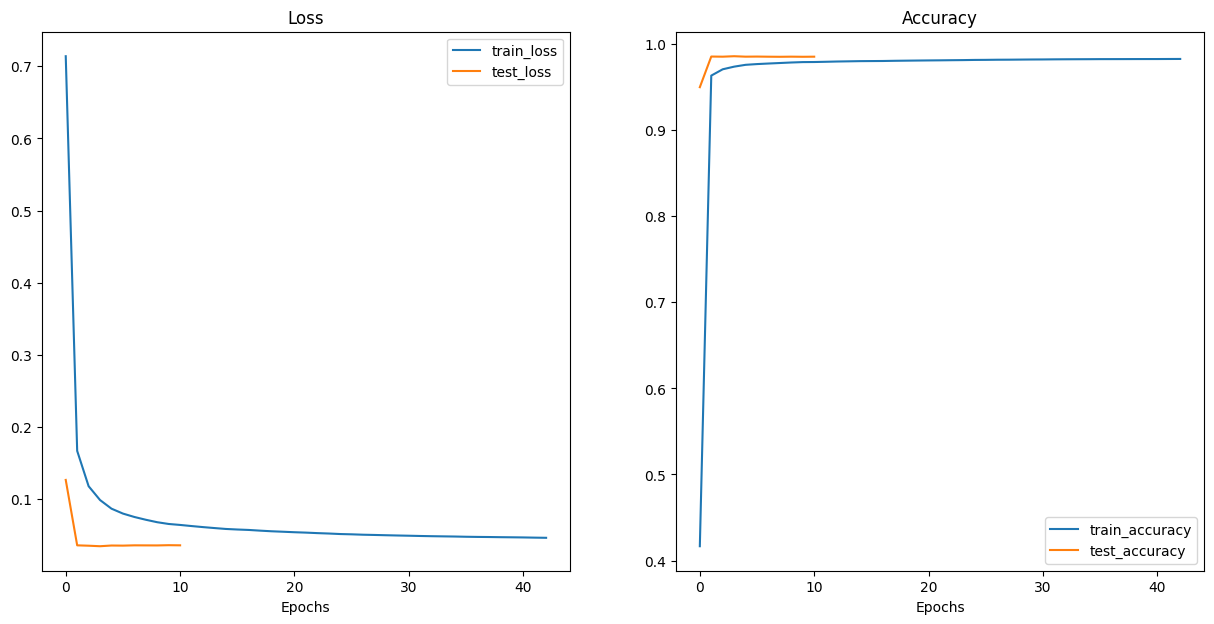

In [18]:
import matplotlib.pyplot as plt
def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    train_epochs = range(len(results["train_loss"]))
    test_epochs = range(len(results["test_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_epochs, loss, label="train_loss")
    plt.plot(test_epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_epochs, accuracy, label="train_accuracy")
    plt.plot(test_epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("per 300 Batch")
    plt.legend()
    
plot_loss_curves(results=plot)

In [19]:
from pytorch_modules import inference_utils
loaded_model = inference_utils.load_model('models/test_model.pt')

In [24]:
import json
with open("outputs/train_results.json", "w") as file:
    json.dump(plot, file, sort_keys=True, indent=4, separators=(',' , ':')) 

In [25]:
loaded_model

DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in